<a href="https://colab.research.google.com/github/jaisidhsingh/Advanced-Computer-Vision/blob/main/GANs/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import torchvision
import torchvision.transforms as T
from tqdm import tqdm


In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self, x):
        return self.block(x)



class ConvTransposeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvTransposeBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.block(x)



class Discriminator(nn.Module):
    def __init__(self, img_channels, features):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(img_channels, features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            ConvBlock(features, features*2, 4, 2, 1),
            ConvBlock(features*2, features*4, 4, 2, 1),
            ConvBlock(features*4, features*8, 4, 2, 1),
            nn.Conv2d(features*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, noise_channels, img_channels, features):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            ConvTransposeBlock(noise_channels, features*16, 4, 1, 0),
            ConvTransposeBlock(features*16, features*8, 4, 2, 1),
            ConvTransposeBlock(features*8, features*4, 4, 2, 1),
            ConvTransposeBlock(features*4, features*2, 4, 2, 1),
            nn.ConvTranspose2d(features*2, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.gen(x)
    

def initialize_weights(model):
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(module.weight.data, 0.0, 0.02)


In [25]:
!wget https://github.com/jaisidhsingh/Advanced-Computer-Vision/blob/main/GANs/GANLoss.py

--2021-06-20 14:34:48--  https://github.com/jaisidhsingh/Advanced-Computer-Vision/blob/main/GANs/GANLoss.py
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘GANLoss.py’

GANLoss.py              [ <=>                ] 137.62K  --.-KB/s    in 0.02s   

2021-06-20 14:34:48 (6.81 MB/s) - ‘GANLoss.py’ saved [140919]



In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Hyperparameters 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
NOISE_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64

transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)


dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms,
                       download=True)


dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
0

gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)

        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \ Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}")

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Epoch [0/5] Batch 0/469                   Loss D: 0.6965, loss G: 0.7647
Epoch [0/5] Batch 100/469                   Loss D: 0.0145, loss G: 4.1303
Epoch [0/5] Batch 200/469                   Loss D: 0.0389, loss G: 3.2806
Epoch [0/5] Batch 300/469                   Loss D: 0.5146, loss G: 1.4136
Epoch [0/5] Batch 400/469                   Loss D: 0.5652, loss G: 0.8797
Epoch [1/5] Batch 0/469                   Loss D: 0.5919, loss G: 1.1731
Epoch [1/5] Batch 100/469                   Loss D: 0.6357, loss G: 1.2194
Epoch [1/5] Batch 200/469                   Loss D: 0.6584, loss G: 1.2223
Epoch [1/5] Batch 300/469                   Loss D: 0.6369, loss G: 0.8980
Epoch [1/5] Batch 400/469                   Loss D: 0.6075, loss G: 0.9026
Epoch [2/5] Batch 0/469                   Loss D: 0.5957, loss G: 1.0880
Epoch [2/5] Batch 100/469                   Loss D: 0.6086, loss G: 1.0998
Epoch [2/5] Batch 200/469                   Loss D: 0.7811, loss G: 1.2398
Epoch [2/5] Batch 300/469      

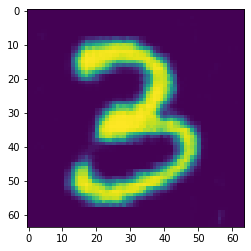

In [30]:
# Testing generator

gen.eval()

TEST_CASES = 1
test = torch.randn(TEST_CASES, NOISE_DIM, 1, 1).to(device)
output = gen(test)

output = output.detach().cpu().numpy()
output = output.reshape((output.shape[0], output.shape[2], output.shape[3]))
import matplotlib.pyplot as plt

for image in output:
    plt.imshow(image)
    plt.show()
